In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [2]:
size = 256
import cv2
import os
images = []
for file in os.listdir("bolek"):
    image = cv2.imread(f"bolek/{file}")
    image = cv2.resize(image, (size,size))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)
images = np.array(images)
images = images.astype('float32') / 255.0

print("images shape",images.shape)

images shape (1640, 256, 256, 3)


In [3]:
smallImages = []
for i in range(images.shape[0]):
    m = cv2.resize(images[i], (int(size/4),int(size/4)))
    smallImages.append(m)
smallImages = np.array(smallImages)
print(smallImages.shape)

(1640, 64, 64, 3)


Small images


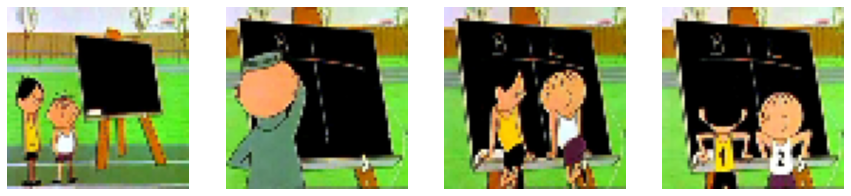

Big images


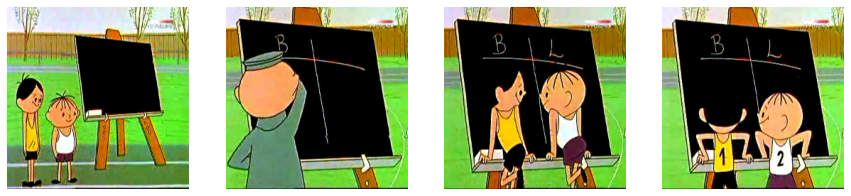

In [4]:
import matplotlib.pyplot as plt
import random
plt.figure(figsize=(15, 15))
n = 4
x = 1
print("Small images")
for i in range(n):
    ax = plt.subplot(1,n, x)
    x = x + 1
    plt.imshow(smallImages[i*100])
    plt.axis("off")
plt.show()
plt.figure(figsize=(15, 15))
x = 1
print("Big images")
for i in range(n):
    ax = plt.subplot(1,n, x)
    x = x + 1
    plt.imshow(images[i*100])
    plt.axis("off")
plt.show()

(1640, 64, 64, 3)
(1640, 256, 256, 3)


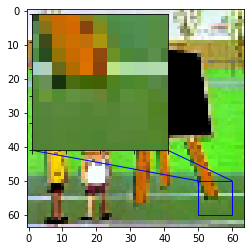

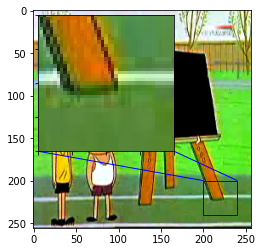

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

def show_image_with_zoom(img,rect=(200,200,240,240)):
    fig, ax = plt.subplots()
    im = ax.imshow(img)
    axins = zoomed_inset_axes(ax, 4, loc=2)
    axins.imshow(img)
    axins.set_xlim(rect[0], rect[2])
    axins.set_ylim(rect[3], rect[1])
    plt.yticks(visible=False)
    plt.xticks(visible=False)
    mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="blue")

print(smallImages.shape)
show_image_with_zoom(smallImages[0],rect=(50,50,60,60))
print(images.shape)
show_image_with_zoom(images[0])

In [6]:
def show_images(minSamples,realSamples,n=1,fig_size=(15,15)):
    #testSamples = trainMaps
    
    resultSamples = autoencoder.predict(minSamples[:3])
    plt.figure(figsize=fig_size)
    print('Reshaped small image')
    i = 0
    show_image_with_zoom(minSamples[i],rect=(50,50,60,60))
    plt.show()

    plt.figure(figsize=fig_size)
    print('Reconstructed images')
    show_image_with_zoom(tf.clip_by_value(resultSamples[i], 0.0, 1.0))
    plt.show()

    plt.figure(figsize=fig_size)
    print('Original images')
    show_image_with_zoom(realSamples[i])
    plt.show()


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input
from tensorflow.keras.layers import UpSampling2D, LeakyReLU, Conv2DTranspose, Concatenate
from tensorflow.keras.initializers import RandomNormal
import autoencoder_models as autoencoders

input_size = size*size*3
code_size = 500

def transpose_model(image_shape):
    input_img = Input(shape=image_shape)
    x = Conv2D(filters = 16, kernel_size = (3, 3), activation='relu', padding='same')(input_img)
    x = Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', padding='same')(x)
    encoded = Conv2D(filters = 16, kernel_size = (3, 3), activation='relu', padding='same', name='encoded')(x)
    x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(encoded)
    x = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    output_img = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    model = Model(input_img, output_img)
    return model

def depth_model(image_shape,upscale_factor=3):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    channels = image_shape[2]
    inputs = Input(shape=image_shape)
    x = Conv2D(64, 5, **conv_args)(inputs)
    x = Conv2D(64, 3, **conv_args)(x)
    x = Conv2D(32, 3, **conv_args)(x)
    x = Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return Model(inputs, outputs)

#autoencoder = transpose_model((64,64,3))
autoencoder = depth_model(image_shape=(None,None,3),upscale_factor=4)

autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 64)    4864      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 48)    13872     
_________________________________________________________________
tf.nn.depth_to_space (TFOpLa (None, None, None, 3)     0         
Total params: 74,128
Trainable params: 74,128
Non-trainable params: 0
_________________________________________________________

410/410 [==============================] - 47s 35ms/step - loss: 0.8347
Epoch 0
Reshaped small image


<Figure size 1080x1080 with 0 Axes>

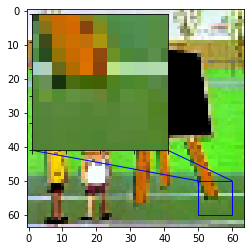

Reconstructed images


<Figure size 1080x1080 with 0 Axes>

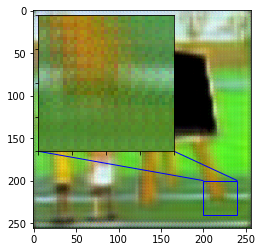

Original images


<Figure size 1080x1080 with 0 Axes>

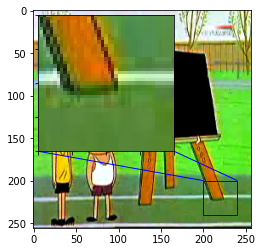

410/410 [==============================] - 13s 32ms/step - loss: 0.4706
Epoch 10
Reshaped small image


<Figure size 1080x1080 with 0 Axes>

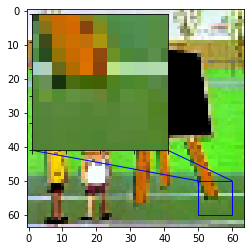

Reconstructed images


<Figure size 1080x1080 with 0 Axes>

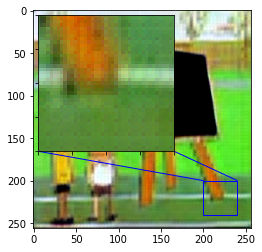

Original images


<Figure size 1080x1080 with 0 Axes>

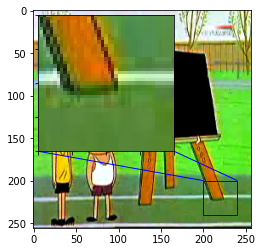

410/410 [==============================] - 14s 33ms/step - loss: 0.4701
Epoch 20
Reshaped small image


<Figure size 1080x1080 with 0 Axes>

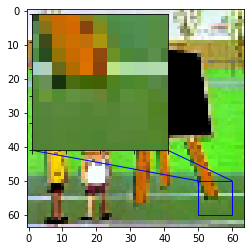

Reconstructed images


<Figure size 1080x1080 with 0 Axes>

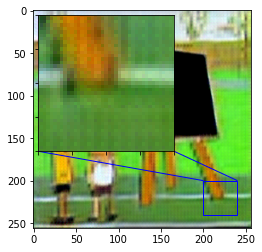

Original images


<Figure size 1080x1080 with 0 Axes>

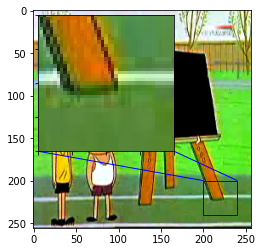

410/410 [==============================] - 14s 34ms/step - loss: 0.4652
Epoch 30
Reshaped small image


<Figure size 1080x1080 with 0 Axes>

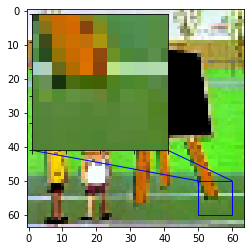

Reconstructed images


<Figure size 1080x1080 with 0 Axes>

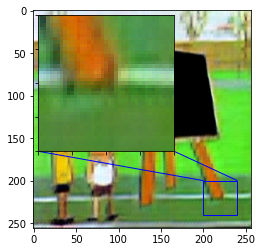

Original images


<Figure size 1080x1080 with 0 Axes>

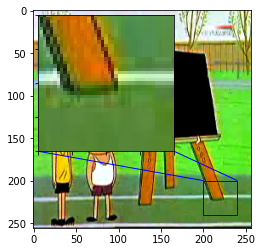

410/410 [==============================] - 14s 34ms/step - loss: 0.4634
Epoch 40
Reshaped small image


<Figure size 1080x1080 with 0 Axes>

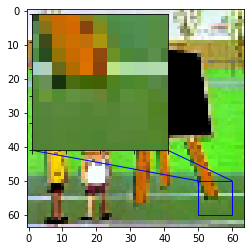

Reconstructed images


<Figure size 1080x1080 with 0 Axes>

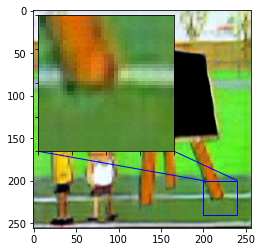

Original images


<Figure size 1080x1080 with 0 Axes>

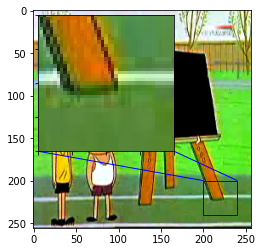

410/410 [==============================] - 14s 33ms/step - loss: 0.4653
Epoch 50
Reshaped small image


<Figure size 1080x1080 with 0 Axes>

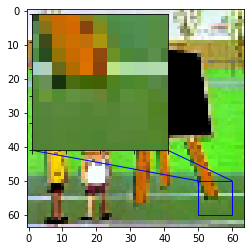

Reconstructed images


<Figure size 1080x1080 with 0 Axes>

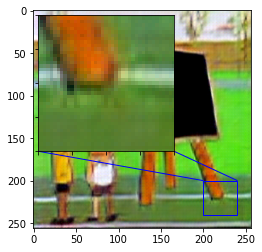

Original images


<Figure size 1080x1080 with 0 Axes>

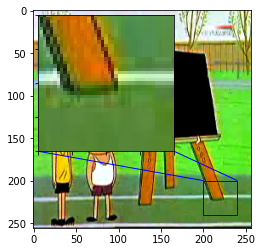

410/410 [==============================] - 14s 35ms/step - loss: 0.4624
Epoch 60
Reshaped small image


<Figure size 1080x1080 with 0 Axes>

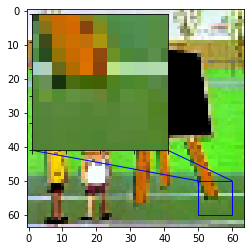

Reconstructed images


<Figure size 1080x1080 with 0 Axes>

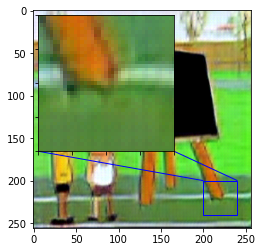

Original images


<Figure size 1080x1080 with 0 Axes>

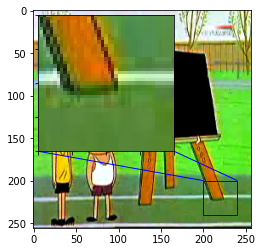

410/410 [==============================] - 14s 34ms/step - loss: 0.4626
Epoch 70
Reshaped small image


<Figure size 1080x1080 with 0 Axes>

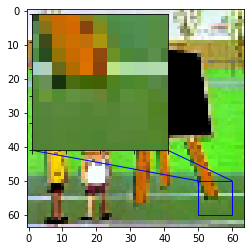

Reconstructed images


<Figure size 1080x1080 with 0 Axes>

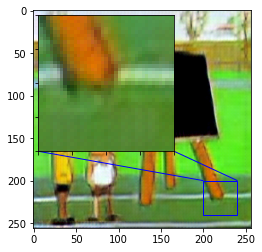

Original images


<Figure size 1080x1080 with 0 Axes>

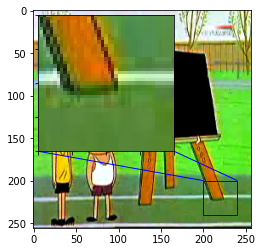

410/410 [==============================] - 15s 36ms/step - loss: 0.4607
Epoch 80
Reshaped small image


<Figure size 1080x1080 with 0 Axes>

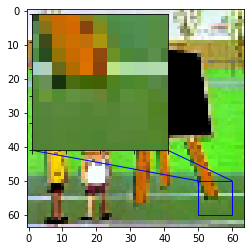

Reconstructed images


<Figure size 1080x1080 with 0 Axes>

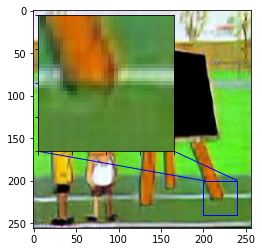

Original images


<Figure size 1080x1080 with 0 Axes>

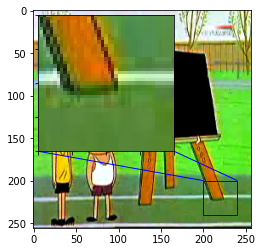

410/410 [==============================] - 16s 39ms/step - loss: 0.4601
Epoch 90
Reshaped small image


<Figure size 1080x1080 with 0 Axes>

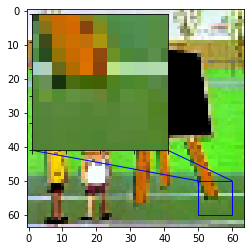

Reconstructed images


<Figure size 1080x1080 with 0 Axes>

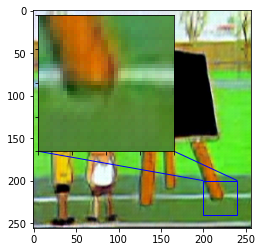

Original images


<Figure size 1080x1080 with 0 Axes>

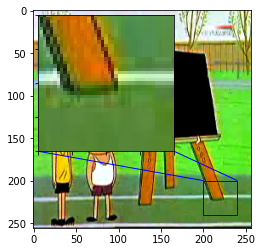

410/410 [==============================] - 14s 35ms/step - loss: 0.4619


In [8]:
for epoch in range(100):
    autoencoder.fit(smallImages, images, batch_size=4, epochs=1)
    if epoch%10==0:
        print("Epoch",epoch)
        show_images(smallImages,images,'training')
    

(1, 72, 96, 3)
Reshaped small image


<Figure size 1080x1080 with 0 Axes>

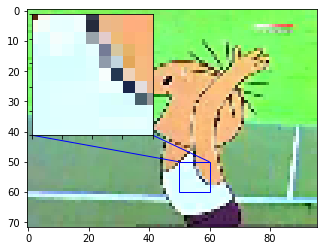

Reconstructed images


<Figure size 1080x1080 with 0 Axes>

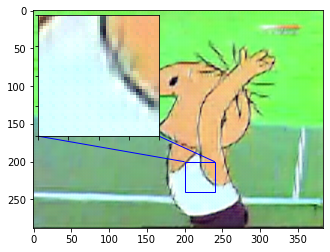

Original images


<Figure size 1080x1080 with 0 Axes>

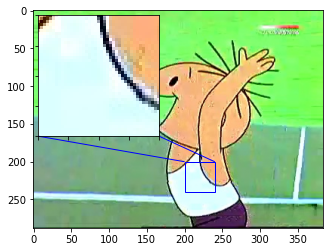

In [10]:
image = cv2.imread(f"bolek/frame1501.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
imageSmall = cv2.resize(image, (int(image.shape[1]/4),int(image.shape[0]/4)))

image = np.expand_dims(image,0)
imageSmall = np.expand_dims(imageSmall,0)

image = image/255.0
imageSmall = imageSmall/255.0
print(imageSmall.shape)
show_images(imageSmall,image,1)